In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.cross_validation import KFold
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score

%matplotlib inline

data_train = pd.read_csv('data.csv')


data_train.sample(3)

/Users/lalitsandeepbhavineni/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
312604,662341065,Our Face's of Violence - An Installtion to Unite,Installations,Art,CAD,2014-07-13,350000.0,2014-05-14 22:16:24,0.0,failed,0,CA,0.00,0.00,325732.90
140733,1714710655,Over the Hill at Create (Canceled),Photography,Photography,GBP,2014-09-15,2500.0,2014-08-16 07:16:44,20.0,canceled,1,GB,33.37,32.68,4085.17
301121,603264233,Superhero Geocaching,Tabletop Games,Games,USD,2014-10-21,500.0,2014-10-03 16:21:11,859.0,successful,23,US,859.00,859.00,500.00


/Users/lalitsandeepbhavineni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


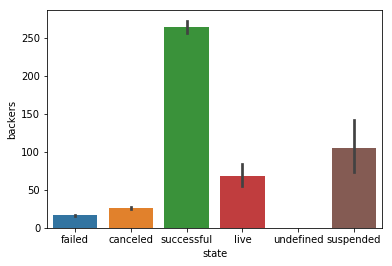

In [2]:
#************  Data Visualization  ******************

sns.barplot(x="state", y="backers", data=data_train);


This graph gives us the count of the various states of the projects.


/Users/lalitsandeepbhavineni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


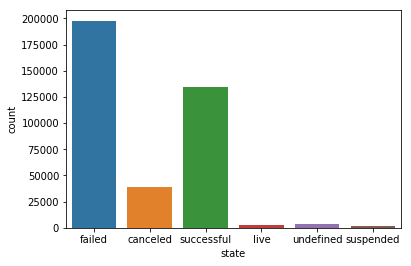

In [3]:
ax = sns.countplot(data_train['state'],label="Count")  

print('This graph gives us the count of the various states of the projects.')

The following correlation map is plotted to identify the features which are highly correlated.


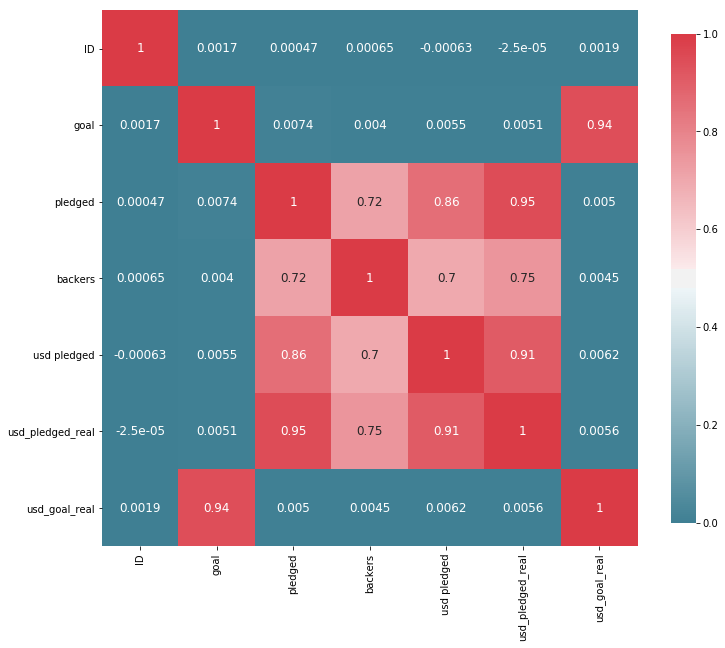

In [4]:
print('The following correlation map is plotted to identify the features which are highly correlated.')
def plot_correlation( df ):
    corr = data_train.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(corr, cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, 
                    annot_kws = { 'fontsize' : 12 }
    )


plot_correlation(data_train)

In [5]:
#*************** Cleaning & Transorming the data   *************************

'''
 Since the differnet columns like usd_pledged_real, usd_goal_real, goal,pledged represent the same quantity money, I tried to reduce them to a single feature so as to reduce the complexity of the model and avoid overfitting.I have done this by creating a new feature which is obtained by subtracting the 2 columns - usd_pledged_real & usd_goal_real . 

'''



'\n Since the differnet columns like usd_pledged_real, usd_goal_real, goal,pledged represent the same quantity money, I tried to reduce them to a single feature so as to reduce the complexity of the model and avoid overfitting.I have done this by creating a new feature which is obtained by subtracting the 2 columns - usd_pledged_real & usd_goal_real . \n\n'

In [6]:
data_train['difference_in_val'] = data_train['usd_pledged_real'] - data_train['usd_goal_real']



In [7]:
'''
 Since the aim of this classification is to predict whether the state is going to be successful or not, I converted the state feature into a binary variable - successful or unsuccessful i.e. 1 or 0  
'''

'\n Since the aim of this classification is to predict whether the state is going to be successful or not, I converted the state feature into a binary variable - successful or unsuccessful i.e. 1 or 0  \n'

In [8]:
data_train['state'] = data_train['state'].replace('successful', '1')

data_train['state'] = data_train['state'].replace(['canceled','failed','live','suspended','undefined'], '0')

data_train['state'] = data_train['state'].astype(str).astype(int)
data_train.head(10)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,difference_in_val
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,0,0,GB,0.00,0.00,1533.95,-1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,0,15,US,100.00,2421.00,30000.00,-27579.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,0,3,US,220.00,220.00,45000.00,-44780.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,0,1,US,1.00,1.00,5000.00,-4999.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,0,14,US,1283.00,1283.00,19500.00,-18217.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,1,224,US,52375.00,52375.00,50000.00,2375.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,1,16,US,1205.00,1205.00,1000.00,205.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,0,40,US,453.00,453.00,25000.00,-24547.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,0,58,US,8233.00,8233.00,125000.00,-116767.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,0,43,US,6240.57,6240.57,65000.00,-58759.43


/Users/lalitsandeepbhavineni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


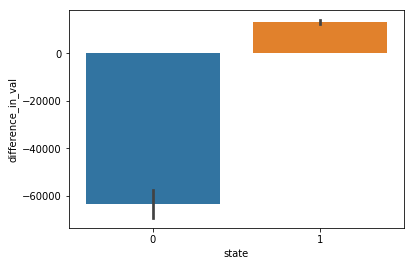

In [9]:
sns.barplot(x="state", y="difference_in_val", data=data_train);


In [10]:
'''
 Since there is a clear relation between sign of difference_in_val and the 2 values of the state feature I converted difference_in_val into binary variable. 
'''

'\n Since there is a clear relation between sign of difference_in_val and the 2 values of the state feature I converted difference_in_val into binary variable. \n'

In [11]:
data_train['difference_in_val'][data_train['difference_in_val']>0]=1

data_train['difference_in_val'][data_train['difference_in_val']<0]=0

/Users/lalitsandeepbhavineni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lalitsandeepbhavineni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
#****************** Transforming Features *********************
print('')
print('If we observe backers feature it is a numerical variable with many different values. This might not help in improving the classification accuracy.')
data_train.backers.describe() 


If we observe backers feature it is a numerical variable with many different values. This might not help in improving the classification accuracy.


count    378661.000000
mean        105.617476
std         907.185035
min           0.000000
25%           2.000000
50%          12.000000
75%          56.000000
max      219382.000000
Name: backers, dtype: float64

In [13]:


print('So I transformed it into a bin variable. ')
print('')

def simplify_backers(df):
    #df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 2, 12, 56, 219382)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.backers, bins, labels=group_names)
    df.backers = categories
    return df

data_train=simplify_backers(data_train)

data_train.head(15)

So I transformed it into a bin variable. 



,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,difference_in_val
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,0,1_quartile,GB,0.00,0.00,1533.95,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,0,3_quartile,US,100.00,2421.00,30000.00,0.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,0,2_quartile,US,220.00,220.00,45000.00,0.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,0,1_quartile,US,1.00,1.00,5000.00,0.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,0,3_quartile,US,1283.00,1283.00,19500.00,0.0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,1,4_quartile,US,52375.00,52375.00,50000.00,1.0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,1,3_quartile,US,1205.00,1205.00,1000.00,1.0
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,0,3_quartile,US,453.00,453.00,25000.00,0.0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,0,4_quartile,US,8233.00,8233.00,125000.00,0.0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,0,3_quartile,US,6240.57,6240.57,65000.00,0.0


In [14]:
print('Encoding of labels to perform Normalization')
print('')
from sklearn import preprocessing
def encode_features(df_train):
    features = ['main_category', 'backers']
    df_combined = df_train[features]
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
    return df_train
    
data_train= encode_features(data_train)
data_train.head(5)

Encoding of labels to perform Normalization



,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,difference_in_val
0,1000002330,The Songs of Adelaide & Abullah,Poetry,12,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,6,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,2,US,100.0,2421.0,30000.00,0.0
2,1000004038,Where is Hank?,Narrative Film,6,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,1,US,220.0,220.0,45000.00,0.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,10,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,0,US,1.0,1.0,5000.00,0.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,6,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,2,US,1283.0,1283.0,19500.00,0.0


In [15]:
print('Splitting the training data. ')
print('')

X_all = data_train.drop(['state', 'ID','name','category','currency','deadline','goal','launched','pledged','state','country','usd pledged','usd_pledged_real','usd_goal_real'], axis=1)
y_all = data_train['state']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)


Splitting the training data. 



In [16]:
print('Fitting and fine tuning the parameters of a model.')

clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)

Fitting and fine tuning the parameters of a model.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9852640196479738


In [18]:
print('Performing K Fold cross validation')
print('')

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Performing K Fold cross validation

Fold 1 accuracy: 0.9666666666666667
Fold 2 accuracy: 0.9887640449438202
Fold 3 accuracy: 0.9662921348314607
Fold 4 accuracy: 1.0
Fold 5 accuracy: 0.9775280898876404
Fold 6 accuracy: 0.9662921348314607
Fold 7 accuracy: 0.9775280898876404
Fold 8 accuracy: 0.9775280898876404
Fold 9 accuracy: 0.9887640449438202
Fold 10 accuracy: 0.9887640449438202
Mean Accuracy: 0.9798127340823971


In [19]:
confusion_matrix(y_test, predictions, labels=[1, 0]) 


array([[25716,   863],
       [  253, 48901]])

In [20]:
f1_score(y_test, predictions, average='binary')  


0.9787622744918931

In [21]:
print('From the K Fold mean accuracy,confusion matrix and F1 score it is clear that the model accurately fits the data')
print('')

From the K Fold mean accuracy,confusion matrix and F1 score it is clear that the model accurately fits the data



In [23]:
print('Saving the model')
print('')
filename = 'saved_model.sav'
joblib.dump(clf, filename)

Saving the model



['saved_model.sav']